# Load data

In [93]:
import pandas as pd
import numpy as np
import re

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [94]:
names_sex = pd.read_csv('data/firstname_with_sex.csv', sep=';')

## Names with sex frequency

In [95]:
names_sex['male_freq'] = names_sex.apply(lambda x: x['male'] / (x['male'] + x['female']), axis=1)

## Transcriptions

In [96]:
transcriptions_sex = pd.read_csv('data/transcriptions_with_sex.csv')
transcriptions_sex

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme
...,...,...,...,...
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme


In [97]:
def extract_pattern(input_string):
    pattern = r'(\b\w+:\s[\w\-\"\s]+ )'
    result = re.findall(pattern, input_string + ' ')

    dico = {}
    for e in result:
        elems = e.split(':')
        dico[elems[0]] = elems[1].strip()

    return dico

In [98]:
extract_pattern(input_string = 'nom: Dupont prénom: Jean Paul date_naissance: 12 relation: fils profession: plombier'
)

{'nom': 'Dupont',
 'prénom': 'Jean Paul',
 'date_naissance': '12',
 'relation': 'fils',
 'profession': 'plombier'}

L'expression régulière précédente est robuste aux '"', aux tirets, aux noms composés, ainsi qu'à la présence de nombres.

In [99]:
transcriptions_sex['extraction'] = transcriptions_sex['prediction'].apply(extract_pattern)

transcriptions_sex[['nom', 'prénom',
       'date_naissance', 'lieux_naissance', 'employeur', 'relation',
       'profession', 'état_civil', 'éducation']] = 'None'

for i in range(transcriptions_sex.shape[0]):
    dico = transcriptions_sex.loc[i, 'extraction']
    for key in dico.keys():
        transcriptions_sex.loc[i, key] = dico[key]

Colonnes abandonnées:
- 'nom' : 20 NaN / 241, mais non informatif par définition
- 'date_naissance' : 1 NaN, mais mélange de dates de naissance et d'âges sans possibilité de convertir les dates en âge (et réciproquement), plus des valeurs aberrantes
- 'éducation' : 238 NaN / 241
- 'état_civil' : 205 NaN / 241 et valeurs aberrantes ou non informatives pour le reste
- 'employeur' : 209 NaN / 241 et valeurs aberrantes ou non informatives pour le reste
- 'lieux_naissance' : 67 NaN / 241 et non informatif par définition

Colonnes gardées :

- 'prénom' : 0 NaN
- 'relation' : 88 NaNs, mais potentiel informatif (mots masculins et féminins à détecter)
- 'profession' : 183 NaNs, mais potentiel informatif (mots masculins et féminins à détecter)

## Récupération des colonnes utiles

In [100]:
df = transcriptions_sex[['prénom', 'relation', 'profession', 'sex']]

In [101]:
# Preprocessing des prénoms
df.loc[:, 'prénom'] = df['prénom'].apply(lambda x: x.lower().replace(" ", "").replace("-", ""))

In [102]:
names_set = set(df['prénom'].to_list())
len(names_set)

110

110 'prénoms' uniques avant preprocessing dans la base retenue

In [103]:
all_names = set(names_sex['firstname'].to_list())
names_diff = names_set.difference(all_names)
len(names_diff)

35

35 'prénoms' sont présents dans la base, mais pas dans le dictionnaire des prénoms disponibles

Parmi la différence : des erreurs de retranscription, des valeurs absurdes, et des vrais prénoms qui ne figurent pas dans la base 'firstname_with_sex'

In [104]:
# Merge avec la base des prénoms
df = df.rename(columns={'prénom': 'firstname'})
merged = df.merge(names_sex[['firstname', 'male_freq']], on=['firstname'], how='left')

# On supprime les lignes pour lesquelles on n'a pas le vrai label ('ambigu')
merged = merged.loc[~(merged['sex'] == 'ambigu')]

## Règles de décision construites à la main

In [105]:
df_decision_rule = merged.copy()

In [106]:
def pred_sex(row):

    # Si le prénom est 100% masculin ou féminin, la classification est naturelle
    if (row['male_freq'] is not None) and (row['male_freq'] >= 0.95):
        return 'homme'
    elif (row['male_freq'] is not None) and (row['male_freq'] <= 0.05):
        return 'femme'
    
    # Sinon, si la relation contient un marqueur évident de masculinité/féminité, la classification est claire
    if any(w in row['relation'] for w in ['mère', 'mere', 'fille', 'soeur', 'femme', 'brue']):
        return 'femme'
    elif any(w in row['relation'] for w in ['père', 'pere', 'fils', 'frere', 'frère', 'chef']):
        return 'homme'

    # Idem pour la profession
    if any(w in row['profession'] for w in ['ière', 'euse']):
        return 'femme'
    elif any(w in row['profession'] for w in ['fils', 'ier', 'eur', 'patron']):
        return 'homme'
    
    # Sinon, on s'en remet à la fréquence de masculinité du prénom
    if (row['male_freq'] is not None) and (row['male_freq'] >= 0.5):
        return 'homme'
    elif (row['male_freq'] is not None) and (row['male_freq'] < 0.5):
        return 'femme'

    return 'homme' # Choix arbitraire si aucune autre information disponible (52% d'hommes dans les données)

In [107]:
# On prédit le sexe sur les échantillons restants
df_decision_rule['sex_pred'] = df_decision_rule.apply(pred_sex, axis=1)

In [108]:
print(classification_report(df_decision_rule['sex'], df_decision_rule['sex_pred']))

              precision    recall  f1-score   support

       femme       0.97      0.91      0.94       107
       homme       0.92      0.98      0.95       125

    accuracy                           0.94       232
   macro avg       0.95      0.94      0.94       232
weighted avg       0.95      0.94      0.94       232



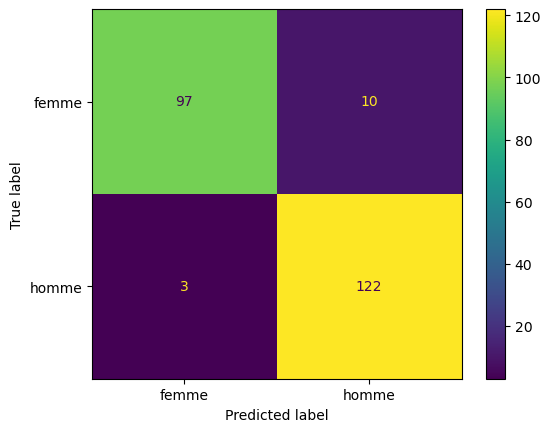

In [109]:
ConfusionMatrixDisplay.from_predictions(df_decision_rule['sex'], df_decision_rule['sex_pred'])

In [110]:
df_decision_rule.loc[df_decision_rule['sex'] != df_decision_rule['sex_pred']]

,firstname,relation,profession,sex,male_freq,sex_pred
25,oarguerite,ep,None,femme,NaN,homme
34,vigmie,Ep,None,femme,NaN,homme
132,gadeleine,p f,None,femme,NaN,homme
138,ctiennette,None,None,femme,NaN,homme
146,marie,cullinière,Lameau,homme,0.004226,femme
188,anne,Emp fils,None,homme,0.001809,femme
193,marthy,None,None,femme,NaN,homme
197,faul,domest,lavane,femme,NaN,homme
217,mareleine,None,None,femme,NaN,homme
219,franco,None,id,femme,NaN,homme


## Modèles à base d'arbres de décision

### Preprocessing

In [111]:
tree_df = merged.copy()

In [112]:
# Encoding de la variable cible : 0 pour les femmes, 1 pour les hommes
tree_df['sex'] = tree_df['sex'].apply(lambda x: 0 if x=='femme' else 1)

In [113]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(tree_df.drop('sex', axis=1), tree_df['sex'], test_size=0.3, random_state=42)

In [114]:
# Target encoding des variables 'firstname' et 'relation'
targ_enc = TargetEncoder(target_type='binary', shuffle=False)
targ_enc.fit(X_train[['firstname', 'relation']], y_train)

X_train[['firstname', 'relation']] = targ_enc.transform(X_train[['firstname', 'relation']])
X_test[['firstname', 'relation']] = targ_enc.transform(X_test[['firstname', 'relation']])

In [115]:
# 80% des personnes pour qui une profession est enregistrée sont des hommes
# 53% des personnes pour qui aucune profession n'est enregistrée sont des femmes
# Binarisation de la variable 'profession', sous la forme 'Inactif' vs 'Actif'
X_train['profession'] = X_train['profession'].apply(lambda x: 0 if x in ['None', 'sp'] else 1)
X_test['profession'] = X_test['profession'].apply(lambda x: 0 if x in ['None', 'sp'] else 1)

In [116]:
# Imputation par la moyenne des NaN présents dans la colonne des fréquences
freq_mean = X_train['male_freq'].mean()
X_train['male_freq'] = X_train['male_freq'].fillna(freq_mean)
X_test['male_freq'] = X_test['male_freq'].fillna(freq_mean)

# Standardisation
std_scaler = StandardScaler()
std_scaler.fit(np.array(X_train['male_freq']).reshape(-1, 1))
X_train['male_freq'] = std_scaler.transform(np.array(X_train['male_freq']).reshape(-1, 1))
X_test['male_freq'] = std_scaler.transform(np.array(X_test['male_freq']).reshape(-1, 1))

### Gradient Boosting Classifier

In [117]:
gb_clf = GradientBoostingClassifier(random_state=421)

# Hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.005, 0.05, 0.01, 0.3],
    'max_depth': [3, 5, 7]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=421),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.05, 0.01, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        85

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

              precision    recall  f1-score   support

           0       0.68      0.90      0.77        30
           1       0.90      0.68      0.77        40

    accuracy                           0.77        70
   macro avg       0.79      0.79      0.77        70
weighted avg       0.80      0.77      0.77        70



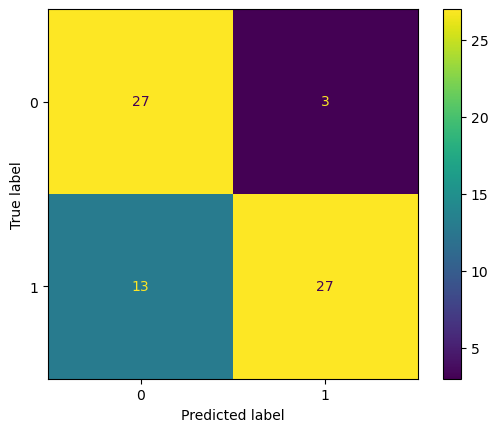

In [118]:
# Predictions avec le meilleur modèle
best_gb_clf = grid_search.best_estimator_
y_pred_train = best_gb_clf.predict(X_train)
y_pred_test = best_gb_clf.predict(X_test)

# Affichage des résultats
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

Observation : decent performance, overfitting on the train set, not enough data overall, and quite simple text representation. Not as good as the manual decision rules.

### Random Forest Classifier

In [119]:
rf_clf = RandomForestClassifier(random_state=421)

# Hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 75, 100, 200],
    'max_depth': [3, 5, None],
    'max_features': ['sqrt', None],
}

# Perform GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=421),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'max_features': ['sqrt', None],
                         'n_estimators': [50, 75, 100, 200]},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        85

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.91      1.00      0.95        40

    accuracy                           0.94        70
   macro avg       0.95      0.93      0.94        70
weighted avg       0.95      0.94      0.94        70



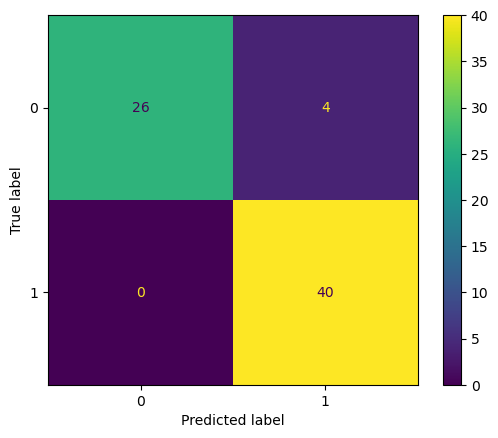

In [120]:
# Prédictions avec le meilleur modèle
best_rf = rf_grid_search.best_estimator_
y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

print(classification_report(y_train, y_pred_train_rf))
print(classification_report(y_test, y_pred_test_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_rf)

Observation : overfitting sur les données d'entraînement, très bons résultats obtenus avec la Random Forest. Toutefois, forte variance des résultats lorsque la seed change (accuracy qui varie entre 0.83 et 0.94) : méthode moins robuste que les critères de classification déterministes. On se demande comment les modèles exploitent les variables qui contiennent beaucoup de 'None'.

## Distributed text representations using a pretrained LLM

### Preprocessing

In [121]:
llm_df = merged.copy()

In [122]:
# Preprocessing du texte : passage en lettres minuscules, et remplacement de 'None' par 'inconnue' dans les colonnes 'relation' et 'profession'
llm_df['relation'] = llm_df['relation'].apply(lambda x: x.lower().replace("none", "inconnue"))
llm_df['profession'] = llm_df['profession'].apply(lambda x: x.lower().replace("none", "inconnue").replace("sp", "aucune"))

# Encoding de la variable cible : 0 pour les femmes, 1 pour les hommes
llm_df['sex'] = llm_df['sex'].apply(lambda x: 0 if x=='femme' else 1)

# Split des données
train, X_test, train_lab, y_test = train_test_split(llm_df.drop('sex', axis=1), llm_df['sex'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train, train_lab, test_size=0.2, random_state=42)

In [123]:
# Imputation par la moyenne des NaN présents dans la colonne des fréquences
freq_mean = X_train['male_freq'].mean()
X_train['male_freq'] = X_train['male_freq'].fillna(freq_mean)
X_val['male_freq'] = X_val['male_freq'].fillna(freq_mean)
X_test['male_freq'] = X_test['male_freq'].fillna(freq_mean)

In [124]:
encode_numbers = True

if encode_numbers:
    X_train['male_freq'] = X_train['male_freq'].apply(lambda x: 'masculin' if x >= 0.5 else 'feminin')
    X_val['male_freq'] = X_val['male_freq'].apply(lambda x: 'masculin' if x >= 0.5 else 'feminin')
    X_test['male_freq'] = X_test['male_freq'].apply(lambda x: 'masculin' if x >= 0.5 else 'feminin')

else:
    X_train['male_freq'] = X_train['male_freq'].apply(lambda x: str(np.round(x, 5)))
    X_val['male_freq'] = X_val['male_freq'].apply(lambda x: str(np.round(x, 5)))
    X_test['male_freq'] = X_test['male_freq'].apply(lambda x: str(np.round(x, 5)))

In [125]:
def aggregate_text(row):
    return f"prenom: {row['firstname']} relation: {row['relation']} profession: {row['profession']} tendance: {row['male_freq']}"

In [126]:
X_train['full_text'] = X_train.apply(lambda x: aggregate_text(x), axis=1)
X_val['full_text'] = X_val.apply(lambda x: aggregate_text(x), axis=1)
X_test['full_text'] = X_test.apply(lambda x: aggregate_text(x), axis=1)

### Tokenisation du texte

In [127]:
from transformers import AutoTokenizer, CamembertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch

from tqdm import tqdm
import functools

In [128]:
tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base")

In [129]:
class TextDataset(Dataset):
    def __init__(self, data, labels) -> None:
        super().__init__()
        self.data = data['full_text'].reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        row = self.data.loc[idx]
        label = self.labels.loc[idx]
        return {'text':row, 'label': label}
    
train = TextDataset(X_train, y_train)
val = TextDataset(X_val, y_val)
test = TextDataset(X_test, y_test)

In [130]:
def tokenize_batch(samples, tokenizer):
    text = [sample['text'] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])

    tokens = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "sentences": text}

In [131]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer))
val_loader = DataLoader(val, batch_size=8, shuffle=True, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer))
test_loader = DataLoader(test, batch_size=8, shuffle=True, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer))

In [132]:
class TextClassifier(nn.Module):
    def __init__(self, encoder, device) -> None:
        super(TextClassifier, self).__init__()

        self.device = device
        self.encoder = encoder.to(self.device)
        self.clf = nn.Linear(in_features=768, out_features=2).to(self.device)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, batch):
        encoded_text = self.encoder(
            input_ids = batch["input_ids"].to(self.device),
            attention_mask = batch["attention_mask"].to(self.device),
            output_hidden_states=True)

        batch_embs = self.average_embeddings(encoded_text["hidden_states"][-1].to(self.device), batch["attention_mask"].to(self.device))
        batch_probs = self.softmax(self.clf(batch_embs))

        return batch_probs

    def average_embeddings(self, embeddings, attention_mask):
        return (attention_mask[..., None] * embeddings).mean(1)

In [133]:
def evaluate(model, loader, device):
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in loader:
            batch_probs = model(batch)
            labels = batch['labels'].to(device)

            _, predicted = torch.max(batch_probs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return np.round(100 * correct / total, 4)


def train(model, train_loader, val_loader, device, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        epoch_loss = 0.

        for batch in tqdm(train_loader):
            
            # Forward pass
            batch_probs = model(batch)
            labels = torch.stack((1 - batch['labels'], batch['labels']), dim=1).float()
            loss = F.binary_cross_entropy(batch_probs, labels.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_acc = evaluate(model=model, loader=train_loader, device=device, name='train')
        val_acc = evaluate(model=model, loader=val_loader, device=device, name='validation')

        print('Epoch {}/{} - Average loss: {:.4f} - Training accuracy: {} - Validation accuracy {}'
                    .format(epoch+1, num_epochs, epoch_loss / len(train_loader), train_acc, val_acc))

In [134]:
camembert = CamembertModel.from_pretrained("almanach/camembert-base")
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TextClassifier(encoder=camembert,
                       device=device)

for name, param in model.named_parameters():
    param.requires_grad = True if name.startswith('clf') else False

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [135]:
train(model=model,
      train_loader=train_loader,
      val_loader=val_loader,
      device=device,
      optimizer=optimizer,
      num_epochs=20)

100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


Epoch 1/20 - Average loss: 0.6483 - Training accuracy: 87.1622 - Validation accuracy 78.3784


100%|██████████| 19/19 [00:05<00:00,  3.26it/s]


Epoch 2/20 - Average loss: 0.5375 - Training accuracy: 88.5135 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.21it/s]


Epoch 3/20 - Average loss: 0.4708 - Training accuracy: 72.973 - Validation accuracy 72.973


100%|██████████| 19/19 [00:07<00:00,  2.68it/s]


Epoch 4/20 - Average loss: 0.4133 - Training accuracy: 89.1892 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch 5/20 - Average loss: 0.3647 - Training accuracy: 89.1892 - Validation accuracy 81.0811


100%|██████████| 19/19 [00:06<00:00,  3.14it/s]


Epoch 6/20 - Average loss: 0.3473 - Training accuracy: 89.8649 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.18it/s]


Epoch 7/20 - Average loss: 0.3217 - Training accuracy: 88.5135 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.18it/s]


Epoch 8/20 - Average loss: 0.3143 - Training accuracy: 92.5676 - Validation accuracy 81.0811


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


Epoch 9/20 - Average loss: 0.2801 - Training accuracy: 89.8649 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


Epoch 10/20 - Average loss: 0.2726 - Training accuracy: 90.5405 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


Epoch 11/20 - Average loss: 0.2644 - Training accuracy: 91.2162 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.22it/s]


Epoch 12/20 - Average loss: 0.2426 - Training accuracy: 91.2162 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.22it/s]


Epoch 13/20 - Average loss: 0.2411 - Training accuracy: 91.8919 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 14/20 - Average loss: 0.2669 - Training accuracy: 88.5135 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 15/20 - Average loss: 0.2249 - Training accuracy: 94.5946 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 16/20 - Average loss: 0.2129 - Training accuracy: 90.5405 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


Epoch 17/20 - Average loss: 0.2063 - Training accuracy: 93.9189 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch 18/20 - Average loss: 0.2010 - Training accuracy: 95.2703 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


Epoch 19/20 - Average loss: 0.1938 - Training accuracy: 91.8919 - Validation accuracy 83.7838


100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


Epoch 20/20 - Average loss: 0.1903 - Training accuracy: 95.2703 - Validation accuracy 83.7838


In [136]:
test_acc = evaluate(model=model,
                    loader=test_loader,
                    device=device,
                    name='test')
print(f'Test accuracy: {np.round(test_acc, 1)} %')

Test accuracy: 95.7 %
